In [1]:
from pymongo import MongoClient
from pprint import pprint
import igraph
import numpy as np
import scipy
import pandas as pd
import sys
import pymongo
import gensim
import re
from gensim import models, corpora
from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from html import unescape
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
 

try:
    client = MongoClient('localhost', 27017) # host, port
except ConnectionFailure as e:
    sys.stderr.write("Could not connect to MongoDB: %s" % e)
    sys.exit(1)

c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# get database with all tweets
db = client.tweets_database

#client.tweets_database.filtered_tweets_noRetweets_english.drop()


filtered_noRetweets_english_onlyPersonal = client.tweets_database.filtered_noRetweets_english_onlyPersonal

client.tweets_database.collection_names()

['cleaned_tweets',
 'filtered_tweets_noRetweets_english',
 'users',
 'filtered_treated_tweets',
 'filtered_noRetweets_english_onlyPersonal',
 'tweets']

In [3]:
import sys
path = 'D:\A_AHNE1\Tweet-Classification-Diabetes-Distress\preprocess'

if path not in sys.path:
    sys.path.insert(0, path)
sys.path

from preprocess import Preprocess
prep = Preprocess()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Stagiaire2014\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Stagiaire2014\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Stagiaire2014\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
NUM_TOPICS = 10
 
# Build the LDA model
lda_model = models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)
 
# Build the LSI model
lsi_model = models.LsiModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

print("LDA Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
 
print("=" * 20)
 
print("LSI Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lsi_model.print_topic(idx, 10))
 
print("=" * 20)

LDA Model:
Topic #0: 0.106*"type" + 0.103*"diabet" + 0.094*"URL" + 0.057*"USER" + 0.055*"2" + 0.043*"1" + 0.018*"year" + 0.012*"diagnos" + 0.011*"thank" + 0.008*"old"
Topic #1: 0.045*"URL" + 0.042*"beat" + 0.035*"diabet" + 0.014*"month" + 0.012*"health" + 0.012*"insur" + 0.011*"follow" + 0.011*"attack" + 0.011*"afford" + 0.011*"heart"
Topic #2: 0.185*"USER" + 0.114*"diabet" + 0.037*"URL" + 0.033*"get" + 0.022*"like" + 0.018*"insulin" + 0.018*"give" + 0.016*"would" + 0.014*"think" + 0.012*"go"
Topic #3: 0.062*"diabet" + 0.043*"URL" + 0.038*"EMOT_LAUGH" + 0.032*"USER" + 0.022*"low" + 0.019*"insulin" + 0.018*"sugar" + 0.017*"calori" + 0.011*"eat" + 0.011*"say"
Topic #4: 0.249*"" + 0.044*"URL" + 0.018*"diabet" + 0.017*"reversediabet" + 0.016*"glucos" + 0.014*"bbc" + 0.012*"sugar" + 0.010*"daddi" + 0.010*"bring" + 0.009*"level"
Topic #5: 0.063*"URL" + 0.061*"diabet" + 0.043*"blood" + 0.024*"lose" + 0.022*"sugar" + 0.020*"high" + 0.020*"weight" + 0.017*"level" + 0.016*"free" + 0.013*"lower"


In [35]:
tweets = []
for tweet in filtered_noRetweets_english_onlyPersonal.find():
    tweets.append((tweet["id_str"], tweet["text"]))
    
print(len(tweets))

tweets_list = [x for (id, x) in tweets]

KeyboardInterrupt: 

In [41]:
dd.shape

(446097, 31515)

In [15]:
import sys
path = 'D:\A_AHNE1\Tweet-Classification-Diabetes-Distress\preprocess'

if path not in sys.path:
    sys.path.insert(0, path)
sys.path

from preprocess import Preprocess
prep = Preprocess() 

from spacy.lang.en import English
    
class CustomVectorizer(CountVectorizer):
    # overwrite the build_analyzer method, allowing one to
    # create a custom analyzer for the vectorizer
        def build_analyzer(self):
            # load stop words using CountVectorizer's built in method
            stop_words = self.get_stop_words()
            
            # create the analyzer that will be returned by this method
            def analyser(tweet):
                #print("tweet")
                #print(tweet)

                tweet = prep.replace_contractions(tweet)
                tweet = prep.replace_hashtags_URL_USER(tweet, mode="delete")
                tweet = prep.tokenize(tweet)
                tweet = prep.remove_punctuation(tweet)

                tweet = prep.preprocess_emojis(tweet)
                tweet = prep.preprocess_emoticons(tweet)
                tweet = prep.remove_non_ascii(tweet)
                tweet = prep.replace_numbers(tweet, mode="delete")
                tweet = prep.to_lowercase(tweet)

                tweet = prep.remove_stopwords(tweet)
                tweet = prep.lemmatize_verbs(tweet)
                tweet = prep.stem_words(tweet)
                tweet = [ x for x in tweet if x not in["diabet", "glucos", "insulin", "type", "1", "2", "", "get", "sugar", "would",
                                                      "go", "know", "take", "give", "say", "one", "could", "would", "people", "look",
                                                      "year", "test", "see", "oh", "via", "bitch", "daddi", "hi", "w", "b", "n", "c",
                                                      "ii", "dr", "rt", "bc", "ok", "think", "make"] ]

                #tweet = ' '.join(tweet)
                #print("new tweet")
                #print(tweet)
                #print("")

                # load spaCy's model for english language
                #spacy.load('en')

                # instantiate a spaCy tokenizer
                #lemmatizer = English()

                # apply the preprocessing and tokenzation steps
                #doc_clean = unescape(tweet).lower()
                #tokens = lemmatizer(doc_clean)
                #lemmatized_tokens = [token.lemma_ for token in tokens]
                #print("lemmatized")
                #print(lemmatized_tokens)

                # use CountVectorizer's _word_ngrams built in method
                # to remove stop words and extract n-grams
                #return lemmatized_tokens
                #word_ngrams = self._word_ngrams(lemmatized_tokens, stop_words)
                #print("word_ngram")
                #print(word_ngrams)
                #print("")
                #return(word_ngrams)
                return tweet
            
            return(analyser)

In [16]:
#stopwords = ["USER", "", "type", "diabet", "1", "2", "insulin", "glucos"]
vectorizer_test = CustomVectorizer(min_df=5, max_df=0.9, lowercase=True, analyzer = 'word' )
                            # stop_words=stopwords, lowercase=True, analyzer = 'word' )

In [17]:
tweets_preprocessed = vectorizer_test.fit_transform(tweets_list)

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🔙 -> delete emoji :BACK_arrow:
INFO: No category set for emoji 🔛 -> delete emoji :ON!_arrow:
INFO: No category set for emoji 🔝 -> delete emoji :TOP_arrow:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: Could not replace emoticon: :3 of the word: 9:30 (<class 'KeyError'>, KeyError('9:30',), <traceback object at 0x00000000209F5E88>)
INFO: No category set for emoji ↪ -> delete emoji :left_arrow_curving_right:
INFO: No category set for emoji ↩ -> delete emoji :right_arrow_curving_left:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: Could not replace 

INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x000000002167AF48>)
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set fo

INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: Could not replace emoticon: ) of the word: ;-) (<class 'KeyError'>, KeyError(';-)',), <traceback object at 0x00000000210839C8>)
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx',), <traceback object at 0x000000002168B788>)


INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👌 -> delete

INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji ✋ -> delete emoji :raised_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🐽 -> delete emoji :pig_nose:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🎈 -> delete emoji :balloon:
INFO: No category set for emoji 🎁 -> delete emoji :wrapped_gift:
INFO: No category set for emoji 🐩 -> delete emoji :poodle:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😒 -> d

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: :d of the word: :d (<class 'KeyError'>, KeyError(':d',), <traceback object at 0x00000000211B4348>)
INFO: No category set for emoji ✋ -> delete emoji :raised_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x00000000211B4C48>)
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category se

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 👑 -> delete emoji :crown:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set f

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♒ -> delete emoji :Aquarius:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 🌻 -> delete emoji :sunflower:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_ro

INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: xd of the word: xdd (<class 'KeyError'>, KeyError('xdd',), <traceback object at 0x00000000216B0508>)
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INF

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO

INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x00000000222D5B88>)
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍮 -> delete emoji :custard:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍨 -> delete emoji :ice_cream:
INFO: No category set for emoji 🍧 -> delete emoji :shaved_ice:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category 

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emo

INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: Could not replace emoticon: :3 of the word: 7:30 (<class 'KeyError'>, KeyError('7:30',), <traceback object at 0x00000000216AF308>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for e

INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rol

INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 💦 -

INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🚲 -> delete emoji :bicycle:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🚴 -> delete emoji :person_biking:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No categor

INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete em

INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No c

INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👸 -> delete emoji :princess:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set f

INFO: Could not replace emoticon: dx of the word: dxd (<class 'KeyError'>, KeyError('dxd',), <traceback object at 0x00000000216796C8>)
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x0000000021660808>)
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🌌 -> delete emoji :milky_way:
INFO: No category set for emoji 🔀 -> delete emoji :shuffle_tracks_button:
INFO: No category set for emoji ⚙ -> delete emoji :gear:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🤔 -> d

INFO: No category set for emoji 😨 -> delete emoji :fearful_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji ✋ -> delete emoji :raised_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No ca

INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_b

INFO: No category set for emoji 📸 -> delete emoji :camera_with_flash:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🍯 -> delete emoji :honey_pot:
INFO: No category set for emoji 🍯 -> delete emoji :honey_pot:
INFO: No category set for emoji 🍯 -> delete emoji :honey_pot:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :dr

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x0000000023343748>)
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No

INFO: No category set for emoji 👹 -> delete emoji :ogre:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set fo

INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ☝ -> delete emoji :index_pointing_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO:

INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000002083D948>)
INFO: Could not replace emoticon: ) of the word: (415) 915-2291 (<class 'KeyError'>, KeyError('(415) 915-2291',), <traceback object at 0x0000000023351088>)
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emo

INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: Could not replace emoticon: : of the word: ]: (<class 'KeyError'>, KeyError(']:',), <traceback object at 0x000000002085D808>)
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 👴 -> delete e

INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 🤠 -> delete emoji :cowboy_hat_face:
INFO: No category set for emoji 🦄 -> delete emoji :unicorn_face:
INFO: No category set for emoji 🥃 -> delete emoji :tumbler_glass:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x0000000020832888>)
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x0000000020832888>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji

INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback 

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🍚 -> delete emoji :cooked_rice:
INFO: No category set for emoji 🍚 -> delete emoji :cooked_rice:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji ♥ -> delete emoji :

INFO: No category set for emoji 🔍 -> delete emoji :left-pointing_magnifying_glass:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No cate

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🏄 -> delete emoji :person_surfing:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No 

INFO: No category set for emoji 🍽 -> delete emoji :fork_and_knife_with_plate:
INFO: No category set for emoji 🏋 -> delete emoji :person_lifting_weights:
INFO: No category set for emoji 🐾 -> delete emoji :paw_prints:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji ❓ -> delete emoji :question_mark:
INFO: No category set for emoji ❓ -> delete emoji :question_mark:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji ❓ -> delete emoji :question_mark:
INFO: No category set for emoji 🐆 -> delete emoji :leopard:
INFO: No category set for emoji 😝 -> delete emoji :face_wi

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🥛 -> delete emoji :glass_of_milk:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx',), <traceback object at 0x00000000209E48C8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: 

INFO: No category set for emoji 🙆 -> delete emoji :person_gesturing_OK:
INFO: No category set for emoji 🙆 -> delete emoji :person_gesturing_OK:
INFO: No category set for emoji 🙆 -> delete emoji :person_gesturing_OK:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x0000000020A0EF08>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 

INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: N

INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😩

INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🏩 -> delete emoji :love_hotel:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No ca

INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 👍 -> delet

INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: Could not replace emoticon: ) of the word: ;') (<class 'KeyError'>, KeyError(";')",), <traceback object at 0x00000000210AC448>)
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :m

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: Could not replace emoticon: D8 of the word: CD8 (<class 'KeyError'>, KeyError('CD8',), <traceback object at 0x000000002108CB48>)
INFO: Could not replace emoticon: D8 of the word: CD8 (<class 'KeyError'>, KeyError('CD8',), <traceback object at 0x000000002108CB48>)
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No catego

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji ☄ -> delete emoji :comet:
INFO: No category set for emoji ⛱ -> delete emoji :umbrella_on_ground:
INF

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji ✨ -

INFO: No category set for emoji 🍍 -> delete emoji :pineapple:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 🍎 -> delete emoji :red_apple:
INFO: No category set for emoji 🍊 -> delete emoji :tangerine:
INFO: No category set for emoji 🍆 -> delete emoji :eggplant:
INFO: No category set for emoji 🌽 -> delete emoji :ear_of_corn:
INFO: No category set for emoji 🥕 -> delete emoji :carrot:
INFO: No category set for emoji 🍍 -> delete emoji :pineapple:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 🍎 -> delete emoji :red_apple:
INFO: No category set for emoji 🍊 -> delete emoji :tangerine:
INFO: No category set for emoji 🍆 -> delete emoji :eggplant:
INFO: No category set for emoji 🌽 -> delete emoji :ear_of_corn:
INFO: No category set for emoji 🥕 -> delete emoji :carrot:
INFO: No category set for emoji 🍍 -> delete emoji :pineapple:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No catego

INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ⛱ -> delete emoji :umbrella_on_ground:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set f

INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 🏣 -> delete emoji :Japanese_post_office:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🏩 -> delete emoji :love_hotel:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🆗 -> delete emoji :OK_button:
INFO: No category set for emoji 🙄 -> delete emoji :fa

INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 🎀 -> delete emoji :ribbon:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 💟 -> delete emoji :heart_decoration:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_

INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000002B371308>)
INFO: No category set for emoji ✋ -> delete emoji :raised_hand:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🤡 -> delete emoji :clown_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for e

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 🌿 -> delete emoji :herb:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍁 -> delete emoji :maple_leaf:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear

INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🥑 -> delete emoji :avocado:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for em

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji ✈ -> delete emoji :airplane:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🏩 -> delete emoji :love_hotel:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 

INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🌺 -> delete emoji :hibiscus:
INFO: No category set for emoji 🍄 -> delete emoji :mushroom:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😩 -> delete emoj

INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INF

INFO: No category set for emoji 🚗 -> delete emoji :automobile:
INFO: No category set for emoji 🏕 -> delete emoji :camping:
INFO: No category set for emoji 🏕 -> delete emoji :camping:
INFO: No category set for emoji 🎇 -> delete emoji :sparkler:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🔒 -> delete emoji :locked:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🗣 -> delete emoji

INFO: No category set for emoji 🧀 -> delete emoji :cheese_wedge:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🌯 -> delete emoji :burrito:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: 

INFO: No category set for emoji 👓 -> delete emoji :glasses:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:


INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set 

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ⚫ -> delete emoji :black_circle:
INFO: No category set for emoji 🔴 -> delete emoji :red_circle:
INFO: No category set for emoji 🔵 -> delete emoji :blue_circle:
INFO: No category set for emoji ⚫ -> delete emoji :black_circle:
INFO: No category set for emoji 🔴 -> delete emoji :red_circle:
INFO: No category set for emoji 🔵 -> delete emoji :blue_circle:
INFO: No category set for emoji ⚫ -> delete emoji :black_circle:
INFO: No category set for emoji 🔴 -> delete emoji :red_circle:
INFO: No category set for emoji 🔵 -> delete emoji :blue_circle:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji ⚫ -> delete emoji :black_circle:
INFO: No category set for emoji 🔴 -> delete emoji :red_circle:
INFO: No category set for emoji 🔵 -> delete emoji :blue_circle:
INFO: No category set for emoji ⚫ -> delete emoji :black_circle:
INFO: No category set 

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: qq of the word: niqqa (<class 'KeyError'>, KeyError('niqqa',), <traceback object at 0x00000000215C3BC8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not 

INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: Could not replace emoticon: :3 of the word: 11:30 (<class 'KeyError'>, KeyError('11:30',), <traceback object at 0x00000000215C36C8>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji ⚾ -> delete emoji :baseball:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 😩 -> delete emoji :we

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x00000000215AB8C8>)
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🏺 -> delete emoji :amphora:
INFO: No category set for emoji ⚱ -> delete emoji :funeral_urn:
INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No cate

INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji 🏋 -> delete emoji :person_lifting_weights:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🔗 -> delete emoji :link:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO:

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤰 -> delete emoji :pregnant_woman:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_

INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoj

INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 🐾 -> delete emoji :paw_prints:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasse

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🏊 -> delete emoji :person_swimming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🚴 -> delete emoji :person_biking:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🍒 -> delete emoji :cherries:
INFO: No category set for emoji 🍌 -> delete emoji :banana:
INFO: No category set for emoji 🍓 -> delete emoji :strawberry:
INFO: No category set for emoji 🍈 -> delete emoji :melon:
INFO: No cate

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🐖 -> delete emoji :pig:
INFO: No category set for emoji 🐖 -> delete emoji :pig:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: Could not replace emoticon: : of the word: do: (<c

INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x0000000036AB5248>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🥂 -> delete emoji :clinking_glasses:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No 

INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🐙 -> delete emoji :octopus:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for 

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍟 -> delete emoji :french_fries:
INFO: No categor

INFO: No category set for emoji 🗑 -> delete emoji :wastebasket:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🤠 -> delete emoji :cowboy_hat_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No ca

INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No cat

INFO: No category set for emoji 💼 -> delete emoji :briefcase:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🏏 -> delete emoji :cricket:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😕 -> delete emoji :con

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👹 -> delete emoji :ogre:
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x0000000036AD0108>)
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No cate

INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🔬 -> delete emoji :microscope:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 🌍 -> delete emoji :globe_showing_Europe-Africa:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji

INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 📟 -> delete emoji :pager:
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx',), <traceback object at 0x0000000036AD9848>)
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🐦 -> delete emoji :bird:
INFO: No category set for emoji 🐦 -> delete emoji :bird:
INFO: No category set for emoji 💀 -> delet

INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🕺 -> delete emoji :man_dancing:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :mid

INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: Could not replace emoticon: :3 of the word: 5:30 (<class 'KeyError'>, KeyError('5:30',), <traceback object at 0x0000000020763288>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤙 -> dele

INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😅 -> delete emo

INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🌅 -> delete emoji :sunrise:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set f

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x0000000020761A88>)
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x0000000036ACBAC8>)
INFO: Could not replace emoticon: dx of the word: undx (<class 'KeyError'>, KeyError('undx',), <traceback object at 0x000000002076D908>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🌙 -> delete emoji :crescent_moon:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No ca

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ☝ -> delete emoji :index_pointing_up:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: : of the word: (: (<class 'KeyError'>, KeyError('(:',), <traceback object at 0x0000000020763D88>)
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🌍 -> delete emoji :globe_showing_Europe-Africa:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> del

INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ⛽ -> delete emoji :fuel_pump:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji 

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💣 -> delete emoji :bomb:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for em

INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: : of the word: (: (<class 'KeyError'>, KeyError('(:',), <traceback object at 0x0000000020775648>)
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🙏 -> delete emoji :folded_han

INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: Could not replace emoticon: :3 of the word: 6:30 (<class 'KeyError'>, KeyError('6:30',), <traceback object at 0x000000002076BD08>)
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🎮 -> delete emoji :video_game:
INFO: No category set for emoji 🙄 -> delete emoji :face_with

INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x0000000021076348>)
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 🤔 -> delete emoji :

INFO: No category set for emoji 🌯 -> delete emoji :burrito:
INFO: No category set for emoji 🥗 -> delete emoji :green_salad:
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: Could not replace emoticon: o.o of the word: info.org (<class 'KeyError'>, KeyError('info.org',), <traceback object at 0x000000002076B448>)
INFO: No category set

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🚴 -> delete emoji :person_biking:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x0000000021066A48>)
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x0000000021066E88>)
INFO: No category set for emoji 🦋

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: Could not replace emoticon: ) of the word: )-: (<class 'KeyError'>, KeyError(')-:',), <traceba

INFO: No category set for emoji 🍋 -> delete emoji :lemon:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: ) of the word: ;-) (<class 'KeyError'>, KeyError(';-)',), <traceback object at 0x000000002105DEC8>)
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji ➰ -> delete emoji :curly_loop:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: ) of the word: ;-) (<class 'KeyError'>, KeyError(';-)',), <traceback object at 0x000000002106EE48>)
INFO: No category set for 

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🤸 -> delete emoji :person_cartwheeling:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x0000000021051888>)
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INF

INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 🍍 -> delete emoji :pineapple:
INFO: No category set for emoji 🍍 -> delete emoji :pineapple:
INFO: No category set for emoji 🍍 -> delete emoji :pineapple:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: :3 of the word: 11:30 (<class 'KeyError'>, KeyError('11:30',), <traceback object at 0x00000000210772C8>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 👅 

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🥑 -> delete emoji :avocado:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🔊 -> delete emoji :speaker_high_volume:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🤷 -> delete emoji :person_shruggi

INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x0000000021040D48>)
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👧 -> delete emoji :girl:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No cat

INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x0000000021079A48>)
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🍞 -> delete emoji :bread:
INFO: No category set for emoji 🥖 -> delete emoji :baguette_bread:
INFO: No category set for emoji 🥞 -> delete emoji :pancakes:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🌭 -> delete emoji :hot_dog:
INFO: No category set for emoji 🍟 -> delete emoji :french_fries:
INFO: No category set for emoji 🍰 -> delete emoji :shortc

INFO: No category set for emoji 🌹 -> delete emoji :rose:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 

INFO: No category set for emoji 📞 -> delete emoji :telephone_receiver:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🌅 -> delete emoji :sunrise:
INFO: No category set for emoji 🌷 -> delete emoji :tulip:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x0000000021062848>)
IN

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x0000000021075448>)
INFO: No category set for emoji 🎶 -> delete emoji :music

INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😩 

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: :d of the word: :d (<class 'KeyError'>, KeyError(':d',), <traceback object at 0x00000000210791C8>)
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x00000000216285C8>)
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face

INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set f

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🍌 -> delete emoji :banana:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 😣 -> delete emoji :persever

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x000000002161CC88>)
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 💊 -> delete emoji :pill:
IN

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🍑 -> delete emoji :peach:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙃 -> delete emo

INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category se

INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👈 -> delete emoji :backhand_index_pointing_left:
INFO: No category set for emoji ☄ -> delete emoji :comet:
INFO: No category set for emoji ⛱ -> delete emoji :umbrella_on_ground:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji

INFO: No category set for emoji 🛎 -> delete emoji :bellhop_bell:
INFO: Could not replace emoticon: ) of the word: )= (<class 'KeyError'>, KeyError(')=',), <traceback object at 0x0000000021647B08>)
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🚺 -> delete emoji :women’s_room:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ➡ -> delete emoj

INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No c

INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000002164F688>)
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🍓 -> delete emoji :strawberry:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category

INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🚨 -> delete emoji :police_car_light:
INFO: No category set for emoji 🚨 -> delete emoji :police_car_light:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:


INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🍊 -> delete emoji :tangerine:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💯 -> d

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🏡 -> delete emoji :house_with_garden:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :li

INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🕺 -> delete emoji :man_dancing:
INFO: No category set for emoji 🏋 -> delete emoji :person_lifting_weights:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ☮ -> delete emoji :peace_symbol:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No c

INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: 0:3 of the word: 10:30 (<class 'KeyError'>, KeyError('10:30',), <traceback object at 0x000000002086F048>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😛 -> delete

INFO: No category set for emoji 🤐 -> delete emoji :zipper-mouth_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000002087AB48>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> d

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emo

INFO: No category set for emoji 🍻 -> delete emoji :clinking_beer_mugs:
INFO: No category set for emoji 🍺 -> delete emoji :beer_mug:
INFO: No category set for emoji 🍻 -> delete emoji :clinking_beer_mugs:
INFO: No category set for emoji 🍺 -> delete emoji :beer_mug:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🙌 -> del

INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
I

INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👁 -> delete emoji :eye:
INFO: No category set for emoji 👁 -> delete emoji :eye:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO:

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🔮 -> delete emoji :crystal_ball:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ♥ -> delet

INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🗑 -> delete emoji :wastebasket:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ✊ -> delete

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🏊 -> delete emoji :person_swimming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for e

INFO: No category set for emoji 🔘 -> delete emoji :radio_button:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category se

INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x0000000022006488>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤷 -> delete 

INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 👵 -> delete emoji :old_woman:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 👧 -> delete emoji :girl:
INFO: Could not replace emoticon: dX of the word: edX (<class 'KeyError'>, KeyError('edX',), <traceback object at 0x0000000022029C88>)
INFO: No category set for emo

INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 👆 -> delete emoji :

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx',), <traceback object at 0x0000000022036F88>)
INFO: No category set for emoji 🤷 -> delete emoji 

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji 🍑 -> delete emoji :peach:
INFO: No category set for emoji 🖕 -> delete e

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😛 -> delete emoji :face_wi

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 👹 -> delete emoji :ogre:
IN

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 📱 -> delete emoji :mobile_phone:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🐾 -> delete emoji :paw_prints:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏼 -> delete emoji :me

INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000002200B688>)
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000002200B5C8>)
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 😟 -> delete emoji :worrie

INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🎎 -> delete emoji :Japanese_dolls:
INFO: No category set for emoji 🍥 -> delete emoji :fish_cake_with_swirl:
INFO: No category set for emoji ☁ -> delete emoji :cloud:
INFO: No category set for emoji 🍣 -> delete emoji :sushi:
INFO: No category set for emoji 🎎 -> delete emoji :Japanese_dolls:
INFO: No category set for emoji 🍥 -> delete emoji :fish_cake_with_swirl:
INFO: No category set for emoji ☁ -> delete emoji :cloud:
INFO: No category set for emoji 🍣 -> delete emoji :sushi:
INFO: No category set for emoji 🎎 -> delete emoji :Japanese_dolls:
INFO: No category set for emoji 🍥 -> delete emoji :fish_cake_with_swirl:
INFO: No category set for emoji ☁ -> delete emoji :cloud:
INFO: No category set for emoji 🍣 -> delete emoji :sushi:
INFO: No category set for emoji 

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000002203A588>)
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🐇 -> delete emoji :rabbit:
INFO: No category set for emoji 🍃 -> delete emoji :leaf_fluttering_in_wind:
INFO: No category set for emoji 💒 -> delete emoji :wedding:
INFO: No category set for emoji 🐑 -> delete emoji :sheep:
INFO: No category set for emoji 🐇 -> delete emoji :rabbit:
INFO: No category set for emoji 🍃 -> delete emoji :leaf_fluttering_in_wind:
INFO: No category set for emoji 💒 -> delete emoji :wedding:
INFO: No category set for emoji 🐑 -> delete emoji :sheep:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_f

INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No categor

INFO: Could not replace emoticon: t.T of the word: fat.To (<class 'KeyError'>, KeyError('fat.To',), <traceback object at 0x0000000022037248>)
INFO: No category set for emoji 🅱 -> delete emoji :B_button_(blood_type):
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💡 -> delete emoji :light_bulb:
INFO: No category set for emoji 💡 -> delete emoji :light_bulb:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emo

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🙆 -> delete emoji :person_gesturing_OK:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ☹ -> delete emoji :frowning_f

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🏫 -> delete emoji :school:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji

INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👵 -> delete emoji :old_woman:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x00000000207B3888>)
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x00000000207B3888>)
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🤡 -> delete emoji :clown_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 🥑 -> delete emoji :avocado:

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🛌 -> delete emoji :person_in_bed:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ▶ -> delete emoji :pla

INFO: No category set for emoji 🌾 -> delete emoji :sheaf_of_rice:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🍇 -> delete emoji :grapes:
INFO: No category set for emoji 🥕 -> delete emoji :carrot:
INFO: No category set for emoji 🥒 -> delete emoji :cucumber:
INFO: No category set for emoji 🌶 -> delete emoji :hot_pepper:
INFO: Could not replace emoticon: : of the word: ]: (<class 'KeyError'>, KeyError(']:',), <traceback object at 0x00000000207BC708>)
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category se

INFO: No category set for emoji 👑 -> delete emoji :crown:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_the

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🍆 -> delete emoji :eggplant:
INFO: No category set for emoji 🍆 -> delete emoji :eggplant:
INFO: Could not replace emoticon: Dx of the word: TEDxSUNYGen (<class 'KeyError'>, KeyError('TEDxSUNYGen',), <traceback object at 0x00000000207CB8C8>)
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :

INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x00000000207D1488>)
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x00000000207D1848>)
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No categor

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤔 -> de

INFO: No category set for emoji 🚨 -> delete emoji :police_car_light:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No 

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🌚 -> delete emoji :new_

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d',), <traceback object at 0x00000000207E9948>)
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for 

INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🍝 -> delete emoji :spaghetti:
INFO: No category set for emoji 🌞 -> delete emoji :sun_with_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x00000000207E9F48>)
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_poin

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: : of the word: (: (<class 'KeyError'>, KeyError('(:',), <traceback object at 0x00000000207E6088>)
INFO: No category set for emoji 🌻 -> delete emoji :sunflower:
INFO: No category set for emoji 🌻 -> delete emoji :sunflower:
INFO: No category set for emoji 🌻 -> delete emoji :sunflower:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 🛌 -> delete emoji :person_in_bed:
INFO: No category set for emoji 📻 -> delete emoji :radio:
INFO: No category set for emoji 💝 -> delete emoji :heart_with_ribbon:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: N

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👤 -> delete emoji :bust_in_silhouette:
INFO: No category set for emoji 👧 -> delete emoji :girl:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_bic

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x00000000207F8608>)
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No categ

INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🚫 -> delete emoji :prohibited:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoj

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🚫 -> delete emoji :prohibited:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_s

INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x00000000208087C8>)
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 🐸 -> delete emoji :frog_face:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👋 -> delet

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🆖 -> delete emoji :NG_button:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😓 -> d

INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO:

INFO: No category set for emoji ⚓ -> delete emoji :anchor:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😏 -> dele

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💉

INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: DX of the word: DXCM (<class 'KeyError'>, KeyError('DXCM',), <traceback object at 0x00000000208A27C8>)
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😨 -> delete emoji :fearful_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No cat

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 😦 -> delete emoji :frowning_face_with_open_mouth:
INFO: No category set for emoji 😦 -> delete emoji :frowning_face_with_open_mouth:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🎉 -> delete emoji :party_pop

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: Could not replace emoticon: : of the word: /o: (<class 'KeyError'>, KeyError('/o:',), <traceback object at 0x00000000208B6B08>)
INFO: Could not replace emoticon: : of the word: /o: (<class 'KeyError'>, KeyError('/o:',), <traceback object at 0x000000002080EB88>)
INFO: No category set for emoji ☠ -> delete emoji :

INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 💵 -> delete emoji :dollar_banknote:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoj

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🚶 -> delete emoji :person_walking:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: Could not replace e

INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😞 -> delete e

INFO: No category set for emoji 🤠 -> delete emoji :cowboy_hat_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤔 -

INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🅱 -> delete emoji :B_button_(blood_type):
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🍖 -> delete emoji :meat_on_bone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ➡ -> 

INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🐨 -> delete emoji :koala:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙈 -> delete emoji

INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: Could not replace emoticon: : of the word: p: (<class 'KeyError'>, KeyError('p:',), <traceback object at 0x00000000208B80C8>)
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emo

INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🛑 -> delete emoji :stop_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set f

INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ ->

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: :3 of the word: 5:30 (<class 'KeyError'>, KeyError('5:30',), <traceback object at 0x00000000208E2A48>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙆 -> delete emoji :person_gesturing_OK:
INFO: No category set for emoji 🏾 -> delete emoji :medium-d

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> del

INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ⚽ -> delete emoji :soccer_ball:
INFO: No category set for emoji ♥ -> dele

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😦 -> delete emoji :frowning_face_with_open_mouth:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO

INFO: No category set for emoji 🔪 -> delete emoji :kitchen_knife:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: Could not replace emoticon: ) of the word: ); (<class 'KeyError'>, KeyError(');',), <traceback object at 0x00000000208FED08>)
INFO: Could not replace emoticon: ) of the word: ); (<class 'KeyError'>, KeyError(');',), <traceback object at 0x00000000208FED08>)
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: Could not replace emoticon: : of the word: (: (<class 'KeyError'>, KeyError('(:',), <traceback object at 0x00000000208FED88>)
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_e

INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👯 -> delete emoji :people_with_bunny_ears_partying:
INFO: No category set for emoji 🌸 -> delete emoji :cherry_blossom:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji 😯 -> delete emoji :hushed

INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: N

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😨 -> delete emoji :fearful_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👄 -> delete emoji :mouth:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_fa

INFO: No category set for emoji 🐬 -> delete emoji :dolphin:
INFO: No category set for emoji 🐬 -> delete emoji :dolphin:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji ❣ -> delete emoji :heavy_heart_exclamation:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🎸 -> delete emoji :guitar:
INFO: No category set for emoji 🎤 -> delete emoji :microphone:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 💵 -> delete emoji :dollar_banknote:

INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 📚 -> delete emoji :books:
INFO: No category set for emoji 📰 -> delete emoji :newspaper:
INFO: No category set for emoji 🗞 -> delete emoji :rolled-up_newspaper:
INFO: No category set for emoji 🔏 -> delete emoji :locked_with_pen:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 🐾 -> delete emoji :paw_pri

INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> de

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 🌙 -> delete emoji :crescent_moon:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO:

INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ☑ -> delete emoji :ballot_box_with_check:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤔 -> 

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No categ

INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 👆 -> delete emoji :backhand_index_pointing_up:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 🙄 ->

INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No cat

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: :| of the word: >:| (<class 'KeyError'>, KeyError('>:|',), <traceback object at 0x000000002092AB48>)
INFO: Could not replace emoticon: :3 of the word: 4:30 (<class 'KeyError'>, KeyError('4:30',), <traceback object at 0x00000000209380C8>)
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for 

INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000002093E588>)
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: :3 of the word: 11:30 (<class 'KeyError'>, KeyError('11:30',), <traceback object at 0x00000000209389C8>)
INFO: No category set for emoji 📟 -> delete emoji :pager:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category 

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category s

INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x000000002094CB48>)
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No categ

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🍆 -> delete emoji :eggplant:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🐰 -> delete emoji :rabbit_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :me

INFO: No category set for emoji 💵 -> delete emoji :dollar_banknote:
INFO: No category set for emoji 💶 -> delete emoji :euro_banknote:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: Could not replace emoticon: :3 of the word: 2:30 (<class 'KeyError'>, KeyError('2:30',), <traceback object at 0x000000002093E908>)
INFO: No category set for emoji 😣 -> delete emoji :perseverin

INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: :3 of the word: 6:30 (<class 'KeyError'>, KeyError(

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 💆 -> delete emoji :person_getting_massage:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ☹ -> delete emoji :

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🍌 -> delete emoji :banana:
INFO: No category set for emoji 🥑 -> delete emoji :avocado:
INFO: No category set for emoji 🥒 -> delete emoji :cucumber:
INFO: No category set for emoji 🍎 -> delete emoji :red_apple:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🕊 -> delete emoji :dove:
INFO: No category set for emoji 🌹 -> delete emoji :rose:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 😅 -> delete emoji

INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👐 -> delete emoji :open_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🐼 -> dele

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 🐋 -> delete emoji :whale:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category set for

INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 😦 -> delete emoji :frowning_face_with_open_mouth:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: N

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 👍

INFO: Could not replace emoticon: :3 of the word: 5:30 (<class 'KeyError'>, KeyError('5:30',), <traceback object at 0x00000000209748C8>)
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 👽 -> delete emoji :alien:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for e

INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🌦 -> delete emoji :sun_behind_rain_cloud:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: Could not replace emot

INFO: No category set for emoji 🤠 -> delete emoji :cowboy_hat_face:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :mediu

INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🚶 -> delete emoji :person_walking:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for e

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🏈 -> delete emoji :american_football:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_reliev

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙆 -> delete emoji :person_gesturing_OK:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: N

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 🤦 -> d

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🚿 -> delete emoji :shower:
INFO: No category set for emoji 💄 -> delete emoji :lipstick:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🌻 -> delete emoji :sunflower:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🐖 -> delete emoji :pig:
INFO: No category set for emoji 🥖 -> delete emoji :baguette_bread:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: Could not re

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ⚫ -> delete emoji :black_circle:
INFO: No category set for emoji ⚪ -> delete emoji :white_circle:
INFO: No category set for emoji 🔴 -> delete emoji :red_circle:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :fema

INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: : of the word: (: (<class 'KeyError'>, KeyError('(:',), <traceback object at 0x0000000020997C88>)
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x0000000020997708>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No cat

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🎤 -> delete emoji :microphone:
INFO: No category set for emoji 🎤 -> delete emoji :microphone:
INFO: No category set for emoji 🎤 -> delete emoji :microphone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medi

INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🚀 -> delete emoji :rocket:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category 

INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🍀 -> delete emoji :four_leaf_clover:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👣 -> delete emoji :footprints:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set fo

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎈 -> delete emoji :balloon:
INFO: No category set for emoji 🎁 -> delete emoji :wrapped_gift:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙆 -> delete emoji :person_gesturing_OK:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙍 -> delete emoji :person_frowning:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
I

INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No category set for emoji 🐈 -> delete emoji :cat:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤚 -> delete emoji :raised_back_of_hand:
INFO: No category set for emoji 📡 -> delete emoji :satellite_antenna:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete e

INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 👱 -> delete emoji :blond-haired_person:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category se

INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙈 -> delet

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👺 -> delete emoji :goblin:
INFO: No category set for emoji 👺 -> delete emoji :goblin:
INFO: No category set for emoji 👺 -> delete emoji :goblin:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji © -> delete emoji :copyright:
INFO: No category set for emoji 🎁 -> delete emoji :wrapped_gift:
INFO: No category set for emoji 🎁 -> delete emoji :wrapped_gift:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🍎 -> delete emoji :red_apple:
INFO: No category set for emoji 🍏 -> delete emoji :green_apple:
INFO: No category set for emoji 🚴 -> delete emoji :person_biking:
INFO: No category set f

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🦁 -> delete emoji :lion_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🔻 -> delete emoji :red_triangle_pointed_down:
INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INF

INFO: No category set for emoji ☝ -> delete emoji :index_pointing_up:
INFO: No category set for emoji ☝ -> delete emoji :index_pointing_up:
INFO: No category set for emoji 🏋 -> delete emoji :person_lifting_weights:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🤓 -> de

INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x00000000210C2208>)
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x00000000209DDDC8>)
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
I

INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_ton

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 🦃 -> delete emoji :turkey:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😅 -> delete em

INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🦃 -> delete emoji :turkey:
INFO: No category set for emoji 🍁 -> delete emoji :maple_leaf:
INFO: No category set for emoji 🦃 -> delete emoji :turkey:
INFO: No category set for emoji 🍁 -> delete emoji :maple_leaf:
INFO: No category set for emoji 📻 -> delete emoji :radio:
INFO: No category set for 

INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for 

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙁 -> delete e

INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: Could not replace emoticon: ) of the word: (310) 475-0617 (<class 'KeyError'>, KeyError('(310) 475-0617',), <traceback object at 0x00000000210D8A48>)
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 🚺 -> delete emoji :women’s_room:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🔹 -> delete emoji :small_blu

INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji

INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x00000000210E8CC8>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🎄 -> delete emoji :Christmas_tree:
INFO: No category set for emoji ☃ -> delete emoji :snowman:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: Could not replace emoticon: ) of the word: ;-) (<class 'KeyError'>, KeyError(';-)',), <traceback object at 0x00000000210E91C8>)
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category s

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 👦 -> delete emoji :boy:
INFO: No category set for emoji ❣ -> delete emoji :heavy_heart_exclamation:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No ca

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🤢 ->

INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: ) of the word: (215) 672-4300 (<class 'KeyError'>, KeyError('(215) 672-4300',), <traceback object at 0x00000000210E8608>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🎄 -> delete emoji :Christmas_tree:
INFO: No category set for emoji 🚑 -> delete e

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙉 -> delete emoji :hear-no-evil_monkey:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ⚾ -> delete emoji :baseball:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x00000000210DB

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji ◀ -> delete emoji :reverse_button:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🍣 -> delete emoji :sushi:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: Could not replace emoticon: :3 of the word: 11:30 (<class 'KeyError'>, KeyError('11:30',), <traceback object at 0x0000000021101588>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😣 -> delete emoji :

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 📌 -> delete emoji :pushpin:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoj

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🚀 -> delete emoji :rocket:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 

INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🎅 -> delete emoji :Santa_Claus:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x0000000021111808>)
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
I

INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 🤸 -> delete emoji :person_cartwheeling:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), 

INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🎅 -> delete emoji :Santa_Claus:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🥂 -> delete emoji :clinking_glasses:
INFO: No category set for emoji ☃ -> delete emoji :snowman:
INFO: No category set for emoji ❄ -> delete emoji :snowflake:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🍟 -> delete emoji :french_fries:
INFO: No category set for emoji 🍗 -> delete emoji :poultry_leg:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for 

INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙆 -> delete emoji :person_gesturing_OK:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 👁 -> delete emoji :eye:
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000002110DF48>)
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: 

INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🎄 -> delete emoji :Christmas_tree:
INFO: No category set for emoji 🏑 -> delete emoji :field_hockey:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000002112B3C8>)
INFO: No category set for emoji 💆 -> delete emoji :person_getting_massage:
INFO: No category set for emoji 🏻 -> delete emoji :l

INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 🤰 -> delete emoji :pregnant_woman:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: Could not replace emoticon: ) of the word: (775) 684-5670 (<class 'KeyError'>, KeyError('(775) 684-5670',), <traceback object at 0x000000002

In [29]:
a = vectorizer_test.inverse_transform(tweets_preprocessed[0])
print(tweets_preprocessed[0])
print(a)
type(tweets_preprocessed)

  (0, 5893)	1
  (0, 5142)	1
  (0, 1722)	1
  (0, 142)	1
  (0, 9004)	1
  (0, 13568)	1
  (0, 2727)	1
  (0, 7795)	1
  (0, 7850)	1
[array(['ffs', 'eat', 'automat', '11am', 'later', 'sandwich', 'buy',
       'idiot', 'im'], dtype='<U46')]


scipy.sparse.csr.csr_matrix

In [19]:
%env JOBLIB_TEMP_FOLDER="D:\A_AHNE1\Tweet-Classification-Diabetes-Distress\jupyter_notebooks\tmp"

env: JOBLIB_TEMP_FOLDER="D:\A_AHNE1\Tweet-Classification-Diabetes-Distress\jupyter_notebooks\tmp"


In [20]:
Numer_topics = 8
lda_tf = LatentDirichletAllocation(n_topics=8, random_state=0, n_jobs=1, verbose=1, max_iter=20)
lda_tf.fit(tweets_preprocessed)

c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=20,
             mean_change_tol=0.001, n_components=10, n_jobs=1, n_topics=8,
             perp_tol=0.1, random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [21]:
from pyLDAvis import sklearn
import pyLDAvis
vis_data = sklearn.prepare(lda_tf, tweets_preprocessed, vectorizer_test, n_jobs=1 )


c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [22]:
pyLDAvis.display(vis_data)

In [23]:
pyLDAvis.save_html(vis_data, "topics_K_8.html")

In [ ]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=lda_tf, texts)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [10, 15, 20]}#, 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

In [ ]:
# Materialize the sparse data
tweets_dense = tweets_preprocessed.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((tweets_dense > 0).sum()/tweets_dense.size)*100, "%")

In [4]:


tweets = []
for tweet in filtered_noRetweets_english_onlyPersonal.find():
    tweet = tweet["text"]
    tweet = prep.replace_contractions(tweet)
    tweet = prep.replace_hashtags_URL_USER(tweet, mode="delete")
    tweet = prep.tokenize(tweet)
    tweet = prep.remove_punctuation(tweet)

    tweet = prep.preprocess_emojis(tweet)
    tweet = prep.preprocess_emoticons(tweet)
    tweet = prep.remove_non_ascii(tweet)
    tweet = prep.replace_numbers(tweet, mode="delete")
    tweet = prep.to_lowercase(tweet)

    tweet = prep.remove_stopwords(tweet)
    tweet = prep.lemmatize_verbs(tweet)
    tweet = prep.stem_words(tweet)
    tweet = [ x for x in tweet if x not in["diabet", "glucos", "insulin", "type", "1", "2", "", "get", "sugar", "would",
                                          "go", "know", "take", "give", "say", "one", "could", "would", "people", "look",
                                          "year", "test", "see", "oh", "via", "bitch", "daddi", "hi", "w", "b", "n", "c",
                                          "ii", "dr", "rt", "bc", "ok", "think", "make"] ]

    tweets.append(tweet)

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🔙 -> delete emoji :BACK_arrow:
INFO: No category set for emoji 🔛 -> delete emoji :ON!_arrow:
INFO: No category set for emoji 🔝 -> delete emoji :TOP_arrow:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji ↪ -> delete emoji :left_arrow_curving_right:
INFO: No category set for emoji ↩ -> delete emoji :right_arrow_curving_left:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No 

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🙏 -> 

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🤐 -> delete emoji :zipper-mouth_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No categor

INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 👴 -> delete emoji :old_man:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 🦋 -> delete emoji :butterfly:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No ca

INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji 👫 -> delete emoji :man_and_woman_holding_hands:
INFO: No category set for emoji ❓ -> delete emoji :question_mark:
INFO: No category set for emoji ❓ -> delete emoji :question_mark:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍨 -> delete emoji :ice_cream:
INFO: No category set for emoji 🍧 -> delete emoji :shaved_ice:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😅 -> delete emoji :s

INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji 🐌 -> delete emoji :snail:
INFO: No category set for emoji 🐸 -> delete emoji :frog_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category 

INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: Could not replace emoticon: =P of the word: =P (<class

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emo

INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🎻 -> delete emoji :violin:
INFO: No category set for emoji 🎻 -> delete emoji :violin:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ☔ -> delete emoji :umbrella_with_rain_drops:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No 

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🌭 -> delete emoji :hot_dog:
INFO: No category set for emoji 🌭 -> delete emoji :hot_dog:
INFO: No category set for emoji 🌭 -> delete emoji :hot_dog:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🍇 -> delete emoji :grapes:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji 🍷 -> delete emoji :wine_glass:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji ✋ -> delete emoji :raised_hand:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ❌ -> delete emoji :cross_mark:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: N

INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🚑 -> delete emoji :ambulance:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 💔 -> d

INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for e

INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: No category set for emoji 🌞 -> delete emoji :sun_with_face:
INFO: No category set for e

INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍊 -> delete emoji :tangerine:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO:

INFO: No category set for emoji 🍎 -> delete emoji :red_apple:
INFO: No category set for emoji 📈 -> delete emoji :chart_increasing:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 📉 -> delete emoji :chart_decreasing:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji ⤵ -> delete emoji :right_arrow_curving_down:
INFO: No category set for emoji ⤵ -> delete emoji :right_arrow_curving_down:
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No category set for emoji 

INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😟 -> delete 

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for 

INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍮 -> delete emoji :custard:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍨 -> delete emoji :ice_cream:
INFO: No category set for emoji 🍧 -> delete emoji :shaved_ice:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍯 

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 👉 -> delete emoji :backhand_i

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😷 -> delete emoji

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 💣 -> delete emoji :bomb:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No categor

INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🕺 -> delete emoji :man_dancing:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji ® -> delete emoji :register

INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: 

INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😩 -> delete emoji :wear

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji 😨 -> delete emoji :fearful_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 💃 -> delete emoji :woman_dan

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 🍳 -> del

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💅 -> delete emoji :nail_polish:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💅 -> delete emoji :nail_polish:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💅 -> delete emoji :nail_polish:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💅 -> delete emoji :nail_polish:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ☕ -> delete e

INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ✋ -> delete emoji :raised_hand:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ‼ -> delete emoji :double_excla

INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🍎 -> delete emoji :red_apple:
INFO: No category set for emoji 🍊 -> delete emoji :tangerine:
INFO: No category set for emoji 🍋 -> delete emoji :lemon:
INFO: No category set for emoji 🍌 -> delete emoji :banana:
INFO: No category set for emoji 🍉 -> delete emoji :watermelon:
INFO: No category set for emoji 🍇 -> delete emoji :grapes:
INFO: No category 

INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👑 -> delete emoji :crown:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 🚑 -> delete emoji :ambulance:
INFO:

INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x000000001545B808>)
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x000000001545D488>)
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x0000000015460188>)
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x0000000015471508>)
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x0000000015490EC8>)
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x0000000015493E08>)
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x00000000154A11C8>)
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: N

INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face

INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🎯 -> delete emoji :direct_hit:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👸 -> delete emoji :princess:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No 

INFO: No category set for emoji 🍛 -> delete emoji :curry_rice:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😜 -> delete emoji :face_with

INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 👶 -> delete emoji :baby:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 👶 -> delete emoji :baby:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🎀 -> delete emoji :ribbon:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No categor

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No categor

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🥘 -> delete emoji :shallow_pan_of_food:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji ✈ -> delete emoji :airplane:
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🥂 -> dele

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
IN

INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🏀 -> delete emoji :basketball:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🐖 -> delete emoji :pig:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinki

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🥑 -> delete emoji :avocado:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ⌚ -> delete emoji :watch:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji ☁ -> delete emoji :cloud:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji ❄ -

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emo

INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 👮 -> delete emoji :police_officer:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😝 -> delete emoji :face_with_st

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No ca

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🤑 -> delete emoji :money-mouth_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points

INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 😼 -> delete emoji :cat_face_with_wry_smile:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😼 -> delete emoji :cat_face_with_wry_smile:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for 

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🎁 -> delete emoji :wrapped_gift:
INFO: No category set for emoji 🎊 -> delete emoji :confetti_ball:
INFO: No category set for emoji 🎉 -> delete emoji :p

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
I

INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji ❣ -> delete emoji :heavy_heart_exclamation:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji ⚡ -> 

INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤰 -> delete emoji :pregnant_woman:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji

INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign

INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji 🏃 -> delete emoji :person

INFO: No category set for emoji 🤠 -> delete emoji :cowboy_hat_face:
INFO: No category set for emoji 🦄 -> delete emoji :unicorn_face:
INFO: No category set for emoji 🥃 -> delete emoji :tumbler_glass:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for 

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😞 -> delete emo

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 🌹 -> delete emoji :rose:
INFO: No category set for emoji 🌹 -> delete emoji :rose:
INFO: No category set for emoji 🌹 -> delete emoji :rose:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji ❓ -> delete emoji :question_mark:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INF

INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category se

INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🐹 -> delete emoji :hamster_face:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: N

INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No catego

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_fa

INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 👼 -> delete emoji :baby_angel:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No category set for emoji 🚗 -> delete emoji :automo

INFO: No category set for emoji 🏊 -> delete emoji :person_swimming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No cate

INFO: No category set for emoji 🍚 -> delete emoji :cooked_rice:
INFO: No category set for emoji 🍚 -> delete emoji :cooked_rice:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 🐾 -> delete emoji :paw_prints:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete 

INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🦊 -> delete emoji :fox_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No ca

INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🔷 -> delete emoji :large_blue_diamond:
INFO: No category set for emoji 🔹 -> delete emoji :small_blue_diamond:
INFO: No category set for emoji 🔷 -> delete emoji :large_blue_diamond:
INFO: No category set for emoji ⛳ -> delete emoji :flag_in_hole:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💎 -> delete emoji :gem_stone:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji ⚡ -> del

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👁 -> delete emoji :eye:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No ca

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🤔 -> delete emoji :

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category se

INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 👑 -> delete emoji :crown:
INFO: No category set

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🚶 -> delete emoji :person_walking:
INFO: No category

INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 🏣 -> delete emoji :Japanese_post_office:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🏩 -> delete emoji :love_hotel:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for e

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤷 -> delete emoji :person_shr

INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🐕 -> delete emoji :dog:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😸 -> delete emoji :grinning_cat_face_with_smiling_eyes:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ➡ -> delete emoji :right

INFO: No category set for emoji 🍷 -> delete emoji :wine_glass:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 📈 -> delete emoji :chart_increasing:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🙃 -> delete emoji :upsi

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤦 -> delete e

INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ✔ -> delete

INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤛 -> delete emoji :left-facing_fist:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emo

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:


INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji 🏫 -> delete emoji :school:
INFO: No category set for emoji 🚨 -> delete emoji :police_car_light:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🍞 -> delete emoji :bread:
INFO: No category set for emoji 🥔 -> delete emoji :potato:
INFO: No category set for emoji 💀 -> de

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:


INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👟 -> delete emoji :running_shoe:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for 

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ⛽ -> delete emoji :fuel_pump:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_wink

INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🍗 -> delete emoji :poultry_leg:
INFO: No category set for emoji 🌭 -> delete emoji :hot_dog:
INFO: No category set for emoji 🥗 -> delete emoji :green_salad:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 🏣 -> delete emoji :Japanese_post_office:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 🌎 -> delet

INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🔋 -> delete emoji :battery:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🔋 -> delete emoji :battery:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🍾 -> delete em

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji ♿ -> delete emoji :wheelchair_symbol:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🌺 -> delete emoji :hibiscus:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 🌸 -> delete emoji :cherry_blossom:
INFO: No category set for emoji 🌸 -> delete emoji :cherry_bl

INFO: No category set for emoji ✋ -> delete emoji :raised_hand:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🤡 -> delete emoji :clown_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set

INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🏩 -> delete emoji :love_hotel:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling

INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍧 -> delete emoji :shaved_ice:
INFO: No category set for emoji 🍨 -> delete emoji :ice_cream:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍮 -> delete emoji :custard:
INFO: No category set for emoji 🍯 -> delete emoji :honey_pot:
INFO: No category set for em

INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 🏼 -> delet

INFO: No category set for emoji 🤰 -> delete emoji :pregnant_woman:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🏩 -> delete 

INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🥑 -> delete emoji :avocado:
INFO: No category set for emoji 🚴 -> delete emoji :person_biking:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😪 -> delete emoji :sl

INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 💍 -> delete emoji :ring:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No categor

INFO: No category set for emoji 🏹 -> delete emoji :bow_and_arrow:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👌 -> delete emoji

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🏩 -> delete emoji :love_hotel:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 🌍 -> delete emoji :globe_showing_Europe-Africa:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 😨 -> delete emoji :fearful_face:
INFO: No category set for emoji 🏝 -> delete emoji :desert_island:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category 

INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🛩 -> delete emoji :small_airplane:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji 

INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category s

INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: 

INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🐝 -> delete emoji :honeybee:
INFO: No category set for emoji 📽 -> delete emoji :film_projector:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji 🔽 -> delete emoji :down_button:
INFO: N

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category 

INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🌭 -> delete emoji :hot_dog:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 🌮 -> delete emoji :taco:
INFO: No category set for emoji 🍟 -> delete emoji :french_fries:
INFO: No category set for emoji 🥞 -> delete emoji :pancakes:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emo

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🍀 -> delete emoji :four_leaf_clover:
INFO: No category set for emoji 🐈 -> delete emoji :cat:
INFO: No category set fo

INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🍀 -> delete emoji :four_leaf_clover:
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 👍 -> 

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🕺 -> delete emoji :man_dancing:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 🍟 -> delete emoji :french_fries:
INFO: No category set for emoji 🍟 -> delete emoji :french_fries:
INFO: No category set for emoji 🍟 -> delete emoji :french_fries:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🥞 -> delete emoji :pancakes:
INFO: No category set for emoji 🥞 -> delete emoji :pancakes:
INFO: No category set for emoji 🥞 -> delete emoji :pancakes:
INFO: No category set for emoji 🌭 -> delete e

INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 👈 -> delete emoji :backhand_index_pointing_left:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category s

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎁 -> delete emoji :wrapped_gift:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emo

INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🆘 -> delete emoji :SOS_button:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♦ -> delete emoji :diamond_suit:
INFO: No category set for em

INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 👈 -> delete emoji :backhand_index_pointing_left:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji ❓ -> delete emoji :question_mark:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 🌹 -> delete emoji :rose:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ⚽ -> delete emoji :soccer_ball:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No cat

INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji ⚾ -> delete emoji :baseball:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 📞 -> delete emoji :telephone_receiver:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji

INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🏺 -> delete emoji :amphora:
INFO: No category set for emoji ⚱ -> delete emoji :funeral_urn:
INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 👇 -> dele

INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_

INFO: No category set for emoji 🔗 -> delete emoji :link:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 👂 -> delete emoji :ear:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😫 -> 

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 🏥 -> delete emoji :hospital:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💃 -> delete emoj

INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤔 -> delete emoji :t

INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😦 -> delete emoji :

INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🍸 -> delete emoji :cocktail_glass:
INFO: No category set for emoji 🍸 -> delete emoji :cocktail_glass:
INFO: No category set for emoji 🍸 -> delete emoji :cocktail_glass:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🌿 -> delete emoji :herb:
INFO: No category 

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👭 -> delete emoji :two_women_holding_hands:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👭 -> delete emoji :two_women_holding_hands:
INFO: No category set for emoji 🌟 -> delete emoji :glowing_star:
INFO: No category set for emoji 🌟 -> delete emoji :glowing_star:
INFO: No category set for emoji 🥘 -> delete emoji :shallow_pan_of_food:
INFO: No category set for emoji 🥘 -> delete emoji :

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji ♨ -> delete emoji :hot_springs:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🌞 -> delete emoji :sun_with_face:
INFO: No category set for emoji 📈 -> delete emoji :chart_increasing:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🥃 -> 

INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🥘 -> delete emoji :shallow_pan_of_food:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🎵 -> delete emoji :musical_note:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> dele

INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🎤 -> delete emoji :microphone:
INFO: No category set for emoji 🎼 -> delete emoji :musical_score:
INFO: No category set for emoji 👁 -> delete emoji :eye:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emo

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: N

INFO: No category set for emoji 🤖 -> delete emoji :robot_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍧 -> delete emoji :shaved_ice:
INFO: No category set for emoji 🍨 -> delete emoji :ice_cream:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍧 -> delete emoji :shaved_ice:
INFO: No category set for emoji 🍧 -> delete emoji :shaved_ice:


INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🍉 -> delete emoji :watermelon:
INFO: No category set for emoji 🍉 -> delete emoji :watermel

INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 🍔 -> de

INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🍯 -> delete emoji :honey_pot:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😎 -> delete emoji :

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🎥 -> delete emoji :movie_camera:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set fo

INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx',), <traceback object at 0x00000000156C4888>)
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😱 -> 

INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 👢 -> delete emoji :woman’s_boot:
INFO: No category set for emoji 👢 -> delete emoji :woman’s_boot:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💍 -> delete emoji :ring:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INF

INFO: No category set for emoji 🙇 -> delete emoji :person_bowing:
INFO: No category set for emoji 🙇 -> delete emoji :person_bowing:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🅱 -> delete emoji :B_button_(blood_type):
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: 

INFO: No category set for emoji 🌅 -> delete emoji :sunrise:
INFO: Could not replace emoticon: :\ of the word: :\ (<class 'KeyError'>, KeyError(':\\',), <traceback object at 0x00000000192EE188>)
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🌅 -> delete emoji :sunrise:
INFO: No category set for emoji 🌷 -> delete emoji :tulip:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_ski

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 🙆 -> delete emoji :person_gesturing_OK:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😑 ->

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No categ

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 📞 -> delete emoji :telephone_receiver:
INFO: No category set for emoji 📱 -> delete emoji :mobile_phone:
INFO: No category set for emoji ☎ -> delete emoji :telephone:
INFO: No category set for emoji 📝 -> delete emoji :memo:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ✋ -> delete emoji :raised_hand:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_ton

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 🤔 -> delete emoji 

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoj

INFO: No category set for emoji 😦 -> delete emoji :frowning_face_with_open_mouth:
INFO: No category set for emoji 👆 -> delete emoji :backhand_index_pointing_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: 

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 📝 -> delete emoji :memo:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female

INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO

INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji ☝ -> delete emoji :index_pointing_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🌻 -> delete emoji :sunflower:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_fa

INFO: No category set for emoji 🍳 -> delete emoji :cooking:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 👵 -> delete emoji :old_woman:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INF

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete em

INFO: No category set for emoji 🤑 -> delete emoji :money-mouth_face:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🍟 -> delete emoji :french_fries:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😷 -> de

INFO: No category set for emoji ⚫ -> delete emoji :black_circle:
INFO: No category set for emoji 🔴 -> delete emoji :red_circle:
INFO: No category set for emoji 🔵 -> delete emoji :blue_circle:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ⚫ -> delete emoji :black_circle:
INFO: No category set for emoji 🔴 -> delete emoji :red_circle:
INFO: No category set for emoji 🔵 -> delete emoji :blue_circle:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ⚫ -> delete em

INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🌅 -> delete emoji :sunrise:
INFO

INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🤑 -> delete emoji :money-mouth_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 👌 -> delete em

INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 💧 -> delete emoji :droplet:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 💧 -> delete emoji :droplet:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🥛 -> delete emoji :glass_of_milk:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🌍 -> delete emoji :globe_showing_Europe-Africa:
INFO: No category set for emoji 🔬 -> delete emoji :microscope:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:


INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :ligh

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 👥 -> delete emoji :busts_in_silhouette:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No

INFO: No category set for emoji 🍨 -> delete emoji :ice_cream:
INFO: No category set for emoji 🍞 -> delete emoji :bread:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji ♨ -> delete emoji :hot_springs:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 🍎 -> delete emoji :red_apple:
INFO: No category set for emoji 🍊 -> delete emoji :tangerine:
INFO: No category set for emoji 🍆 -> delete emoji :eggplant:
INFO: No category set for emoji 🌽 -> delete emoji :ear_of_corn:
INFO: No category set for emoji 🥕 -> delete emoji :carrot:
INFO: No category set for emoji 🍍 -> delete emoji :pineapple:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 🍎 -> delete emoji :red_apple:
INFO: No category set for emoji 🍊 -> delete emoji :tangerine:
I

INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🐐 -> delete emoji :goat:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO

INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🍉 -> delete emoji :watermelon:
INFO: No category set for emoji 🍗 -> delete emoji :poultry_leg:
INFO: No category set for emoji 🥕 -> delete emoji :carrot:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😋 

INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🎈 -> delete emoji :balloon:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 💝 -> delete emoji :heart_with_ribbon:
INFO: No category set for emoji 😛 -> delete emoj

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 💨 -> delete emoji :dashing_away:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🥇 -> delete emoji :1st_place_medal:
INFO: No category set for emoji 🖖 -> delete emoji :vulcan_salute:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No c

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🦄 -> delete emoji :unicorn_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ✌ -> delete emoji :victory_

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face

INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😦 -> delete emoji :frowning_face_with_open_mouth:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No

INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 💭 -> delete emoji :thought_balloon:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🐉 -> delete emoji :dragon:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_su

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinkin

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👈 -> delete emoji :backhand_index_pointing_left:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set fo

INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
IN

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💨 -> delete emoji :dashing_away:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 💨 -> delete emoji :dashing_away:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_f

INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No cat

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 💯 -> delete emoji :hundred_poin

INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji ➰ -> delete emoji :curly_loop:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ➰ -> delete emoji :curly_loop:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 🍋 -> delete emoji :lemon:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 

INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x000000001E87A948>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🌹 -> delete emoji :rose:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🏥 -> delete emoji :hospital:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🎈 -> delete emoji :balloon:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_to

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🍻 -> delete emoji :clinking_beer_mugs:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INF

INFO: No category set for emoji 🍷 -> delete emoji :wine_glass:
INFO: No category set for emoji 🍷 -> delete emoji :wine_glass:
INFO: No category set for emoji 🍷 -> delete emoji :wine_glass:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🌴 -> delete emoji :palm_tree:
INFO: No category set for emoji 🌴 -> delete emoji :palm_tree:
INFO: No category set for emoji 🌴 -> delete emoji :palm_tree:
INFO: No category set for emoji 🌴 -> delete emoji :palm_tree:
INFO: No category set for emoji 🍷 -> delete emoji :wine_glass:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 🍷 -> delete emoji :wine_glass:
INFO: No category set for emoji 🍻 -> delete emoji :clinking_beer_mugs:
INFO: No category set for emoji 👶 -> delete e

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🍻 -> delete emoji :clinking_beer_mugs:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍺 -> delete emoji :beer_mug:
INFO: No category set for emoji 🍺 -> delete emoji :beer_mug:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for em

INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 🍻 -> delete emoji :clinking_beer_mugs:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍷 -> delete emoji :wine_glass:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 🥂 -> delete emoji :clinking_glasses:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set 

INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🍷 -> delete emoji :wine_glass:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_wi

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👐 -> delete emoji :open_hands:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO

INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🙃 -> delete emoj

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🌟 -> delete emoji :glowing_star:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx',), <traceback objec

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delet

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 💪 -> delete emoji 

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INF

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🌈 -> delete emoji :rainbow:
INFO: No category set for emoji 🍑 -> delete emoji :peach:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 👽 -> delete emoji :alien:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🎂 -> 

INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ⬇ -> delete emoji :down_

INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 👽 -> delete emoji :alien:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx',), <traceback object at 0x0000000

INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: :d of the word: :d (<class 'KeyError'>, KeyError(':d',), <traceback object at 0x000000001E545308>)
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> de

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 👐 -> delete emoji :open_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 💊 ->

INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍌 -> delete emoji :banana:
INFO: No category set for emoji 🚀 -> delete emoji :rocket:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category se

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ✈ -> delete emoji :airplane:
INFO: No category set for emoji 👜 -> delete emoji :handbag:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤐 -> delete emoji :zipper-mouth_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🐍 -> delete emoji :snake:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🐾 -> delete emoji :paw_prints:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🤔 ->

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 🍨 -> delete emoji :ice_cream:
INFO: No category set for emoji 🍟 -> delete emoji :french_fries:
INFO: No category set for emoji 🍗 -> delete emoji :poultry_leg:
INFO: No category set for emoji 🌯 -> delete emoji :burrito:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍫 -> delete emoji :chocol

INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_si

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🦋 -> delete emoji :butterfly:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🤑 -> delete emoji :money-mouth_face:
INFO: No category set for emoji 🤑 -> delete emoji :money-mouth_face:
INFO: No category set for em

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💩 -> delete e

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No categ

INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_fac

INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: xd of the word: xd (<class 'KeyError'>, KeyError('xd',), <traceback object at 0x000000001945FF88>)
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ☄ -> delete emoji :comet:
INFO: No category set for emoji ⛱ -> delete emoji :umbrella_on_ground:
INFO: No category set for emoji 💎 -> delete emoji :gem_stone:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_

INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🍾 -> delete emoji :bottle_with_popping_cork:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No cate

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji ✖ -> delete emoji :heavy_multiplication_x:
INFO: No category set for emoji ✖ -> delete emoji :heavy_multiplication_x:
INFO: No category set for emoji 🤠 -> delete emoji :cowboy_hat_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💩 -> delete emoji 

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for 

INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No cate

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙉 -> delete emoji :hear-no-evil_monkey:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🗝 -> delete emoji :old_key:
INFO: No category set for emoji 🦄 -> delete emoji :unicorn_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 🍵 -> delete emoji :teacup_without_handle:
INFO: No category set for emoji 🍁 -> delete emoji :maple_leaf:
INFO: No category set for emoji 🐵 -> delete emoji :monkey_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No categ

INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO:

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No cat

INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 💍 -> delete emoji :ring:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set f

INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🍻 -> delete emoji :clinking_beer_mugs:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: 

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 🚫 -> delete emoji :prohibited:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No catego

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💀 -> delete emoji :skul

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🅱 -> delete emoji :B_button_(blood_type):
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: 

INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for 

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoj

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👴 -> delete emoji :old_man:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No cat

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 👸 -> delete emoji :princess:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💪 -> de

INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 🔬 -> delete emoji :microscope:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🔬 -> delete emoji :microscope:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🔬 -> delete emoji :microscope:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 👍 -

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category 

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🎅 -> delete emoji :Santa_Claus:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:


INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No categ

INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👁 -> delete emoji :eye:
I

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🍴 -> delete emoji :fork_and_knife:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 💉 -> delete em

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🔮 -> delete emoji :crystal_ball:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😪 -> delet

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💆 -> delete emoji :person_getting_massage:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set f

INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete em

INFO: No category set for emoji 🏊 -> delete emoji :person_swimming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji

INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 📦 -> delete emoji :package:
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🚴 ->

INFO: No category set for emoji 🤖 -> delete emoji :robot_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raisin

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🛑 -> delete emoji :stop_sign:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🔺 -> delete emoji :red_triangle_pointed_up:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😥 -> delete emoji :disappointed

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx',), <traceback object at 0x000000001D8B6948>)
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🙄 -> d

INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for 

INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🅱 -> delete emoji :B_button_(blood_type):
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🚴 -> delete emoji :person_biking:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🏋 -> delete emoji :person_lifting_weights:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😨 -> delete e

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🎧 -> delete emoji :headphone:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:


INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😋 -> delete emoj

INFO: No category set for emoji 🎯 -> delete emoji :direct_hit:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No cate

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😣 -> delete emoji :perseverin

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🍷 -> delete emoji :wine_glass:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 👇 -> delete emoji :back

INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🍆 -> delete emoji :eggplant:
INFO: No category set for emoji 📱 -> delete emoji :mobile_phone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 🏥 -> delete emoji :hospital:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji ⚽ -> delete emoji :soccer_ball:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🌼 -> delete emoji :blossom:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mo

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :per

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🎁 -> delete emoji :wrapped_gift:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🎗 -> delete emoji :reminder_ribbon:
INFO: No category set for emoji 👑

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🚑 -> delete emoji :ambulance:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💡 -> delete emoji :light_bulb:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😩 -> delete emoji

INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ☄ -> delete emoji :comet:
INFO: No category set for emoji ⛱ -> delete emoji :umbrella_on_ground:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🍸 -> delete emoji :cocktail_glass:
INFO: No category set for emoji 🙏 -> delete emoji :folde

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx',), <traceback object at 0x0000000006EE7F88>)
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💀 -> de

INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:

INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO:

INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
IN

INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete 

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 

INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍆 -> delete emoji :eggplant:
INFO: No category set for emoji 🍆 -> delete emoji :eggplant:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🐭 -> delete emoji :mouse_face:
INFO: No category set for emoji 🐰 -> delete emoji :rabbit_face:
INFO: No category s

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ✔ 

INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 📚 -> delete emoji :books:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji ✏ -> delete emoji :pencil:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏻 -> delete emo

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🐸 -> delete emoji :frog_face:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamus

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete e

INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx',), <traceback object at 0x000000000DD817C8>)
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🚨 -> delete emoji :police_car_light:


INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ❣ -> delete emoji :heavy_heart_exclamation:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👵 -> delete emoji :old_woman:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category se

INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 💆 -> delete emoji :person_getting_massage:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🤙 -> delete emoj

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🛌 -> delete emoji :person_in_bed:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ▶ -> delete emoji :pla

INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙃 -> del

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🦄 -> delete emoji :unicorn_face:
INFO: No category set for emoji 🦄 -> delete emoji :unicorn_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 📈 -> delete emoji :chart_increasing:
INFO: No category set for emoji 📉 -> delete emoji :chart_decreasing:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🐻 -> delete emoji :bear_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_

INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😨 -> delete emoji :fearful_face:
INFO: No category set

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 👀 -> del

INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 🍌 -> delete emoji :banana:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> de

INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🍁 -> delete emoji :maple_leaf:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set f

INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_to

INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set f

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ⚙ -> delete emoji :gear:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji ♥ -> delete emoji

INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji ✈ -> delete emoji :airplane:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emo

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🙃 

INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d',), <traceback object at 0x0000000020876508>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🚆 -> delete emoji :train:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO:

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No cat

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🔴 -> delete emoji :red_circle:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: N

INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 💐 -> delete emoji :bouquet:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
I

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🍝 -> delete emoji :spaghetti:
INFO: No category set for emoji 🌞 -> delete emoji :sun_with_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x000000001EF8DB48>)
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_h

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji ☹ -> delete emoji :frown

INFO: No category set for emoji 🌻 -> delete emoji :sunflower:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 🛌 -> delete emoji :person_in_bed:
INFO: No category set for emoji 📻 -> delete emoji :radio:
INFO: No category set for emoji 💝 -> delete emoji :heart_with_ribbon:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_to

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 🤸 -> delete emoji :person_cartwheeling:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤸 -> delete em

INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_ey

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 🌈 -> delete emoji :rainbow:
INFO: No category set for emoji 🤔 

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ☝ -> delete emoji :index_pointing_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🏌 -> delete emoji :person_golfing:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO

INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 🥊 -> delete emoji :boxing_glove:
INFO: No category set for emoji 🥊 -> delete emoji :boxing_glove:
INFO: No category set for emoji 🥊 -> delete emoji :boxing_glove:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for em

INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🐕 -> delete emoji :dog:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for e

INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 👆 -> delete emoji :backhand_index_pointing_up:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji ‼ -> delete emoji :double_excl

INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emo

INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No c

INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji 

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category se

INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💝 -> delete emoji :heart_with_ribbon:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_h

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 💟 -

INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No 

INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No categ

INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set fo

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No category set for emoji 👹 -> delete emoji :ogre:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:


INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🌈 -> delete emoji :rainbow:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🐨 -> delete emoji :koala:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category se

INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for e

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete em

INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoj

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete 

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🍂 -> delete emoji :fallen_leaf:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ⏩ -> delete emoji :fast-forward_button:
INFO: No category set for emoji ⏩ -> delete emoji :fast-forward_button:
INFO: No category set for emoji ⏪ -> delete emoji :fast_reverse_button:
INFO: No category set for emoji ⏪ -> delete emoji

INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 💑 -> delete emoji :couple_with_heart:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👶 -> delete emoji :baby:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No cat

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👈 -> delete emoji :backhand_index_pointing_left:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👈 -> delete emoji :backhand_index_pointing_left:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 📱 -> delete emoji :mobile_phon

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🆖 -> delete emoji :NG_button:
INFO: No category set for emoji 🆖 -> delete emoji :NG_button:
INFO: No category set for emoji 🦄 -> delete emoji :unicorn_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji ⚽ -> delete emoji :soccer_ball:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙄 -> dele

INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No 

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 👖 -> delete emoji :jeans:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_hea

INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji ⏳ -> delete emoji :hourglass_with_flowing_sand:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ✌ -> 

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set 

INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🍐 -> delete emoji :pear:
INFO: No category set for emoji 🍐 -> delete emoji :pear:
INFO: No category set for emoji 🍐 -> delete emoji :pear:
INFO: No category set for emoji 🥊 -> delete emoji :boxing_glove:
INFO: No category set for emoji 🆘 -> delete emoji :SOS_button:
INFO: No category set for emoji © -> delete emoji :copyright:
INFO: No category set for emoji

INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 🎩 -> delete emoji :top_hat:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 📈 -> delete emoji :chart_increasing:
INFO: No category set for emoji 📉 -> delete emoji :chart_decreasing:
INFO: No category set for emoji 📈 -> delete emoji :chart_increasing:
INFO: No category set for emoji 📉 -> delete emoji :chart_decreasing:
INFO: No category set for emoji 📈 -> delete emoji :chart_increasing:
INFO: No category set for emoji 📉 -> delete emoji :chart_decreasing:
INFO: No category set for emoji 📈 -> delete emoji :chart_increasing:
INFO: No category set for emoji 📉 -> delete emoji 

INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🍊 -> delete emoji :tangerine:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No cate

INFO: No category set for emoji 🍱 -> delete emoji :bento_box:
INFO: No category set for emoji 🍣 -> delete emoji :sushi:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💧 -> delete emoji :droplet:
INFO: No category set for emoji 🍓 -> delete emoji :strawberry:
INFO: No category set for emoji 🍍 -> delete emoji :pineapple:
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji 🦋 -> delete emoji :butterfly:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙌 -> delete emo

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set 

INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO

INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🛑 -> delete emoji :stop_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> del

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ⛄ -> delete emoji :snowman_without_snow:
INFO: No category set for emoji 🌀 -> delete emoji :cyclone:
INFO: No category set for emoji ⛄ -> delete emoji :snowman_without_snow:
INFO: No category set for emoji 🌀 -> delete emoji :cyclone:
INFO: No category set for emoji ⛄ -> delete emoji :snowman_without_snow:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emo

INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emo

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🚶 -> delete emoji :person_walking:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🤦

INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙆 -> delete emoji :person_gesturing_OK:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🤴 -> delete emoji :prince:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🍈 -> delete emoji :melon:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
I

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🌟 -> delete emoji :glowing_star:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🤑 -> delete emoji :money-mouth_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No cat

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💆 -> delete emoji :person_getting_massage:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🌟 -> delete emoji :glowing_star:
INFO: No category set for emoji 🌈 -> delete emoji :rainbow:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 📧 -> delete emoji :e-mail:
INFO: No category set for emoji 👪 -> delete emoji :family:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set 

INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category se

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🎥 -> delete emoji :movie_camera:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🎨 -> delete emoji :artist_palett

INFO: No category set for emoji 😨 -> delete emoji :fearful_face:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 💝 -> delete emoji :heart_with_ribbon:
INFO: No category set for emoji 🐝 -> delete emoji :honeybee:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 💍 -> delete emoji :ring:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rollin

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 👈 -> delete emoji :backhand_index_pointing_left:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete 

INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🔪 -> delete emoji :kitchen_knife:
INFO: No category set for emoji 🔪 -> delete emoji :kitchen_knife:
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set

INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🌋 -> delete emoji :volcano:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji 

INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ☑ -> delete emoji :ballot_box_with_check:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👍 -> delete em

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: 

INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍧 -> delete emoji :shaved_ice:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:

INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🐻 -> delete emoji :bear_face:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emo

INFO: No category set for emoji 📚 -> delete emoji :books:
INFO: No category set for emoji 📰 -> delete emoji :newspaper:
INFO: No category set for emoji 🗞 -> delete emoji :rolled-up_newspaper:
INFO: No category set for emoji 🔏 -> delete emoji :locked_with_pen:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 🐾 -> delete emoji :paw_prints:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ☝ -> delete emoji :index_pointing_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ☝ -> delete emoji :index_pointing_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No cate

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 📦 -> delete emoji :package:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji ✌ -> delete emoji :

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🐄 -> delete emoji :cow:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalmin

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🕵 -> delete emoji :detective:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 🙃 -> delete emoji :upside-dow

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji ☄ -> delete emoji :comet:
INFO: 

INFO: No category set for emoji 🌼 -> delete emoji :blossom:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🔊 -> delete emoji :speaker_high_volume:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ⏭ -> delete emoji :next_track_button:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💀 -> 

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO

INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😨 -> delete emoji :fearful_face:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :he

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emo

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🌍 -> delete emoji :globe_showing_Europe-Africa:
INFO: No category set for emoji 🔛 -> delete emoji :ON!_arrow:
INFO: No category set for emoji 👣 -> delete emoji :footprints:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emo

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x00000000156B8B88>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set

INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 🌻 -> delete emoji :sunflower:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x00000000186BB5C8>)
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji

INFO: No category set for emoji ❣ -> delete emoji :heavy_heart_exclamation:
INFO: No category set for emoji 💝 -> delete emoji :heart_with_ribbon:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💍 -> delete emoji :ring:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙉 -> delete emoji :hear-no-evil_monkey:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 🚑 -> delete emoji :ambulance:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 🚑 -> delete emoji :ambu

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ❌ -> delete emoji :cross_mark:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolli

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sw

INFO: No category set for emoji 🚜 -> delete emoji :tractor:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤦 -> delete emoji :pers

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No categ

INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🥂 -> delete emoji :clinking_glasses:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emo

INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🦄 -> delete emoji :unicorn_face:
INFO: No category set for emoji 🦄 -> delete emoji :unicorn_face:
INFO: No category set for emoji 🐝 -> delete emoji :honeybee:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤷 -> delete emoji :person_shruggin

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set

INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO:

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
I

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No c

INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💯 -> delete emoji :hundred_po

INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 🐵 -> delete emoji :monkey_face:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍷 -> delete emoji :wine_glass:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🐕 -> delete emoji :dog:
INFO: No category set for emoji 🐾 -> delete emoji :paw_prints:
INFO: No category set for emoji 🐾 -> delete emoji :paw_prints:
INFO: No category set for emoji 🐾 -> delete emoji :paw_prints:
INFO: No category set for emoji 🐾 -> delete emoji :paw_prints:
INFO: No category set for emoji 🐾 -> delete emoji :paw_prints:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🤷 -> d

INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_r

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 🚴 -> delete emoji :person_biking:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 👁 -> delete emoji :eye:
INFO: No category set for emoji 👁 -> delete emoji :eye:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No ca

INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😑 -> dele

INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoj

INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💵 -> delete emoji :dollar_banknote:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone

INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍷 -> delete emoji :wine_glass:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category set for emoji 🚶 -> delete emoji :person_walking:
INFO: No category set for emoji 🚶 -> delete emoji :person_walking:
INFO: No category set for emoji 🚶 -> delete emoji :person_walking:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category set for

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji 🤖 -> delete emoji :robot_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category

INFO: No category set for emoji 🥕 -> delete emoji :carrot:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙇 -> delete emoji :person_bowing:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:


INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🍷 -> delete emoji :wine_glass:
INFO: No category set for emoji ❎ -> delete emoji :cross_mark_button:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🏥 -> delete emoji :hospital:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category s

INFO: No category set for emoji 🍺 -> delete emoji :beer_mug:
INFO: No category set for emoji 🍺 -> delete emoji :beer_mug:
INFO: No category set for emoji 🍾 -> delete emoji :bottle_with_popping_cork:
INFO: No category set for emoji 🍾 -> delete emoji :bottle_with_popping_cork:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 📜 -> delete emoji :scroll:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :

INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ⚽ -> delete emoji :soccer_ball:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emo

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🐈 -> delete emoji :cat:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😨 -> delete emoji :fearful_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🌦 

INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🥓 -> delete emoji :bacon:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙇 -> delete emoji :person_bowing:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 🌟 -> delete emoji :glowing_star:
INFO: No category set for emoji 🌟 -> delete emoji :glowing_star:
INFO: No category set for emoji 🌟 -> delete emoji :glowing_star:
INFO: No category set for emoji 🌀 -> delete emoji :cyclone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set f

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤠 -> delete emoji :cowboy_hat_face:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤷 -> delete emoji 

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🌿 -> delete emoji :herb:
INFO: No category set for emoji 📡 -> delete emoji :satellite_antenna:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙏

INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🚶 -> delete emoji :person_walking:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤐 -> delete emoji :zipper-mouth_face:
INFO: No category set for emoji 🦋 -> delete emoji :butterfly:
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🙃 -> delete em

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INF

INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤦 -> del

INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🛑 -> delete emoji :stop_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :cla

INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😬 -> delet

INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍨 -> delete emoji :ice_cream:
INFO: No category set for emoji 🍧 -> delete emoji :shaved_ice:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No c

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: 

INFO: No category set for emoji ⛓ -> delete emoji :chains:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💤 -> delete emoji :zzz:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 👄 -> delete emoji :mouth:
INFO: No category set for emoji 👄 -> delete emoji :mouth:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_t

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set 

INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 💎 -> delete emoji :gem_stone:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🥗 -> delete emoji :green_s

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤡 -> delete emoji :clown_face:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🥇 -> delete emoji :1st_place_medal:
INFO: No category set for 

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category

INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for 

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 👭 -> delete emoji :two_women_holding_hands:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 

INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: Could not replace emoticon: =P of the w

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍜 -> delete emoji :steaming_bowl:
INFO: No category set for emoji 🤠 -> delete emoji :cowboy_hat_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🍏 -> delete emoji :green_apple:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for 

INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🦋 -> delete emoji :butterfly:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🚶 -> delete emoji :person_walking:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -

INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🤑 -> delete emoji :money-mouth_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙃 -> del

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🦋 -> delete emoji :butterfly:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 💀

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙃 -> delete emoji :upsi

INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🔵 -> delete emoji :blue_circle:
INFO: No category set for emoji 🦋 -> delete emoji :butterfly:
INFO: No category set for emoji 💎 -> delete emoji :gem_stone:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 👀 -> delete emoji :

INFO: No category set for emoji 👁 -> delete emoji :eye:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 📸 -> delete emoji :camera_with_flash:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji 

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 👱 -> delete emoji :blond-haired_person:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🍃 -> delete emoji :leaf_fluttering_in_wind:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💗 -> delete emoji

INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🦋 -> delete emoji :butterfly:
INFO: No category set for emoji 💎 -> delete emoji :gem_stone:
INFO: No category set for emoji ❄ 

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 📚 -> delete emoji :books:
INFO: No category set for emoji 

INFO: No category set for emoji 🎁 -> delete emoji :wrapped_gift:
INFO: No category set for emoji 🎁 -> delete emoji :wrapped_gift:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🍎 -> delete emoji :red_apple:
INFO: No category set for emoji 🍏 -> delete emoji :green_apple:
INFO: No category set for emoji 🚴 -> delete emoji :person_biking:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🌸 -> delete emoji :cherry_blossom:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 👴 -> delete emoji :old_man:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: N

INFO: No category set for emoji 🍑 -> delete emoji :peach:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🕰 -> delete emoji :mantelpiece_clock:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set

INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for em

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone

INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🍌 -> delete emoji :banana:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set f

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ✅ -> delete emoji 

INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👈 -> delete emoji :backhand_index_pointing_left:
INFO: No category set for emoji 👈 -> delete emoji :backhand_index_pointing_left:
INFO: No category set for emoji 👈 -> delete emoji :backhand_index_pointing_left:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤰 -> delete emoji :pregnant_woman:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set

INFO: No category set for emoji 🎄 -> delete emoji :Christmas_tree:
INFO: No category set for emoji 🎄 -> delete emoji :Christmas_tree:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🍽 -> delete emoji :fork_and_knife_with_plate:
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medica

INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No catego

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_po

INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👇 -> delete emoji :backhand_index_pointing_down:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🚑 -> delete emoji :ambulance:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji ☝ -> delete emoji :index_pointing_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INF

INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🏟 -> delete emoji :stadium:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_fa

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🕵 -> delete emoji :detective:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :f

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No category set for emoji 🏅 -> delete emoji :sports_medal:
INFO: No category set for emoji 🏆 -> delete emoji :trophy:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙇 -> delete emoji :person_bowing:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO:

INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💧 -> delete emoji :droplet:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category se

INFO: No category set for emoji 🙆 -> delete emoji :person_gesturing_OK:
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🌱 -> delete emoji

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 💃 -> delete emoji :woman_danci

INFO: No category set for emoji 🕴 -> delete emoji :man_in_business_suit_levitating:
INFO: No category set for emoji 🍺 -> delete emoji :beer_mug:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤧 -> delete emoji :sneez

INFO: No category set for emoji 🔹 -> delete emoji :small_blue_diamond:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🔵 -> delete emoji :blue_circle:
INFO: No category set for emoji 🌀 -> delete emoji :cyclone:
INFO: No category set for emoji 🔷 -> delete emoji :large_blue_diamond:
INFO: No category set for emoji 🐕 -> delete emoji :dog:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👈 -> delete emoji :backhand_index_pointing_left:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> de

INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ➡ -> delete 

INFO: No category set for emoji 🔴 -> delete emoji :red_circle:
INFO: No category set for emoji 💈 -> delete emoji :barber_pole:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No 

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 📡 -> delete emoji :satellite_antenna:
INFO: No category set for emoji 🎅 -> delete emoji :Santa_Claus:
INFO: No category set for emoji ⛄ -> delete emoji :snowman_without_snow:
INFO: No category set for emoji 🎄 -> delete emoji :Christmas_tree:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
I

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No ca

INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :h

INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 🤚 -> delete emoji :raised_back_of_hand:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:


INFO: No category set for emoji 👴 -> delete emoji :old_man:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 💟 -> delete emoji :heart_decoration:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤞 -> delete

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🥛 -> delete emoji :glass_of_milk:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No c

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emo

INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🦄 -> delete emoji :unicorn_face:
INFO: No category set for emoji 🦋 -> delete emoji :butterfly:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category se

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete 

INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category se

INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😸 -> delete emoji :grinning_cat_face_with_smiling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 ->

INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 🎨 -> delete emoji :artist_palette:
INFO: No category set for emoji 🗿 -> delete emoji :moai:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 📌 -> delete emoji :pushpin:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_s

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🍆 -> delete emoji :eggplant:
INFO: No category set for emoji 💸 -> delete emoji :money_with_wings:
INFO: No category set for emoji 🦉 -> delete emoji :owl:
INFO: No category set for emoji 🏆 -> delete emoji :trophy:
INFO: No category set for emoji 🎳 -> delete emoji :bowling:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category s

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🖊 -> delete emoji :pen:
INFO: No category set for emoji 📰 -> delete emoji :newspaper:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for 

INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: No category set for emoji ⚗ -> delete emoji :alembic:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No categor

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category 

INFO: No category set for emoji 🕺 -> delete emoji :man_dancing:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 💟 -> delete emoji :heart_decoration:
INFO: No category set for emoji 💟 -> delete emoji :heart_decoration:
INFO: No category set f

INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji ⚠ -> delete emoji :warning:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤢 -> delete e

INFO: Could not replace emoticon: :d of the word: :d (<class 'KeyError'>, KeyError(':d',), <traceback object at 0x0000000021677308>)
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍮 -> delete emoji :custard:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🎧 -> delete emoji :headphone:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -

INFO: No category set for emoji 🎅 -> delete emoji :Santa_Claus:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: N

INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💼 -> delete emoji :briefcase:
INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💼 -> delete emoji :briefcase:
INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💼 -> delete emoji :br

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji ⭐ -> delete emoji :white_medium_star:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🎅 -> delete emoji :Santa_Claus:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No 

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji ⏩ -> delete emoji :fast-forward_button:
INFO: No category set for emoji ⏪ -> delete emoji :fast_reverse_button:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🍾 -> delete emoji :bottle_with_popping_cork:
INF

INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 🤸 -> delete emoji :person_cartwheeling:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji

INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx',), <traceback object at 0x000000001AA584C8>)
INFO: No category set for emoji 🍓 -> delete emoji :strawberry:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
IN

INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏋 -> delete emoji :person_lifting_weights:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🎓 -> delete emoji :graduation_cap:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏋 -> delete emoji :person_lifting_weights:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category

INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 💭 -> delete emoji :thought_balloon:
INFO: No category set for emoji ◀ -> delete emoji :reverse_button:
INFO: No category set for emoji 👂 -> delete emoji :ear:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set f

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ➡ -> delete emoji :righ

INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🎄 -> delete emoji :Christmas_tree:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :wear

INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🥃 -> delete emoji :tumbler_glass:
INFO: No category set for emoji 🥂 -> delete emoji :clinking_glasses:
INFO: No category set for emoji 👑 -> delete emoji :crown:
INFO: No category set for emoji 🎟 -> delete emoji :admission_tickets:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No

INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji 🌞 -> delete emoji :sun_with_face:
INFO: No category set for emoji 🍳 -> delete emoji :cooking:
INFO: No category set for emoji 🥛 -> delete emoji :glass_of_milk:
INFO: No category set for emoji 🔗 -> delete emoji :link:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 🥓 -> delete emoji :bacon:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🚵 -> delete emoji :person_mountain_biking:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category se

In [48]:
import sys
path = 'D:\A_AHNE1\Tweet-Classification-Diabetes-Distress\defines'

if path not in sys.path:
    sys.path.insert(0, path)
#sys.path

path = 'D:\A_AHNE1\Tweet-Classification-Diabetes-Distress\emotion_codes'

if path not in sys.path:
    sys.path.insert(0, path)
#sys.path

from defines import *
from emotion_codes import UNICODE_EMOJI
#from emotion_codes import EMOTICONS_UNICODE
from emotion_codes import EMOTICONS
from emotion_codes import EMOJI_TO_CATEGORY
from emotion_codes import Emotions

Patterns.EMOTICONS_PATTERN

re.compile(r'(\}:‑\)|D:<|<\(_ _\)>|\(\+o\+\)|:\(|:\]|:‑<|\(ーー;\)|:\'‑\(|\(\._\.\)|:\*|:-\)\)|\(\*_\*\)|:O|8‑0|D:|:-\}|\|‑O|<:‑\||:#|:‑/|o_0|\(;_;|\(\^_\^\)|:Þ|\(\*\^\.\^\*\)|=\)|\(=\^\·\·\^=\)|xD|>:‑\)|:‑\[|m\(__\)m|>:\)|\(\'_\'\)|:\)|:‑c|\(；一_一\)|>:\[|:‑,|>\^_\^<|:‑J|:>|\(\＾ｖ\＾\)|:o|\(\^_-\)|\(\・\・?|%\)|d:|D8|\(\^o\^\)|m\(_ _\)m|\|;‑\)|\(-_-\)|\(ToT\)|8D|\(\^o\^\)／|\(^\^\)|:‑Þ|O:‑\)|DX|\(__\)|\(\＾ｕ\＾\)|>:[(\\)]|\(一一\)|:‑\(|:x|o\.O|\(T_T\) \(;_;\)|\(\^_\^\)/|\(ToT\)/~~~|=p|B\^D|;;|\(\(\+_\+\)\)|:‑\)|\（\^—\^\）|>:/|:p|;\)|;n;|\(\^\)o\(\^\)|\):|\(>_<\)|\(\^_\^\)v|>:\(|:‑x|%‑\)|\(-"-\)|3:‑\)|:‑D|\(‘A`\)|\(:_;\)|:‑o|:P|8-\)|\(\*\^\^\)v|:S|\(\^J\^\)|:X|:b|:O o_O|=[(\\)]|XD|\^/\^|\(>_<\)>|:\'\(|:‑\||\(~_~;\) \(・\.・;\)|=\]|\^m\^|\(#\^\.\^#\)|=L|\(-_-\)/~~~ \($\·\·\)/~~~|D=|\)\^o\^\(|:-\]|\(\^\.\^\)|<m\(__\)m>|>:O|:<|=/|\(\*\^0\^\*\)|0:\)|0:‑3|:‑#|D‑\':|;\]|\*-\)|\(=\^\·\^=\)|>;\)|\(;_;\)/~~~|\(\^—\^\）|:3|:c|0:‑\)|:->|D;|\(-_-\)zzz|:L|X‑P|;‑\)|=3|\(?_?\)|\(\(d[-_-]b\)\)|T\.T|\*\)|:\^\)|\(o\|o\)

dx <class 'str'>
False
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000004182E1C8>)
dx <class 'str'>
False
: <class 'str'>
True
xd <class 'str'>
False
Dx <class 'str'>
False


['hallo', 'dxs', 'yes', 'xdd', 'TEDxPurdueU']

In [46]:
import string
cleaned_tweet = []
for word in tweets[10]:
    #if word not in string.punctuation and word != '...' and word != '…' and word != '..':
    if word not in string.punctuation and word not in ['...', '…', '..', "\n", "\t", " "] :
        cleaned_tweet.append(word)

cleaned_tweet
#prep.remove_punctuation(tweets[10])

['caitlyn',
 'confid',
 'individu',
 'morn',
 'show',
 'us',
 'new',
 'pump',
 'work',
 'dem']

In [5]:
dictionary = Dictionary(tweets)

In [6]:
len(dictionary)

77743

In [7]:
corpus = [dictionary.doc2bow(text) for text in tweets]
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]

In [10]:
import matplotlib.pyplot as plt 

def evaluate_graph(dictionary, corpus, texts, list_num_topics):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    logPerplex_list = []
    for num_topics in list_num_topics:
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=0)
        lm_list.append(lm)
        logPerplex_list.append(lm.log_perplexity(corpus))
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    #x = list_num_topics #range(1, limit)
    #plt.plot(x, c_v)
    #plt.xlabel("num_topics")
    #plt.ylabel("Coherence score")
    #plt.legend(("c_v"), loc='best')
    #plt.show()
    
    return lm_list, c_v, logPerplex_list




list_num_topics = [8, 10, 12, 15, 17, 20, 22, 25]
lmlist, c_v, logPerplex_list = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=tweets, list_num_topics=list_num_topics)

<Figure size 640x480 with 1 Axes>

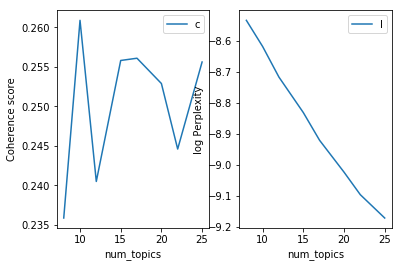

In [11]:
plt.figure()

plt.subplot(121)
plt.plot(list_num_topics, c_v)
plt.xlabel("num_topics")
plt.ylabel("Coherence score")
plt.legend(("c_v"), loc='best')

plt.subplot(122)
plt.plot(list_num_topics, logPerplex_list)
plt.xlabel("num_topics")
plt.ylabel("log Perplexity")
plt.legend(("logPerpl"), loc='best')

plt.show()

In [14]:
c_v[np.argmax(c_v)]

0.2609065647358268

In [15]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

print(type(lmlist[np.argmax(c_v)]))
print(type(corpus))
print(type(dictionary))
vis = pyLDAvis.gensim.prepare(lmlist[np.argmax(c_v)], corpus, dictionary, n_jobs=1)


<class 'gensim.models.ldamodel.LdaModel'>
<class 'list'>
<class 'gensim.corpora.dictionary.Dictionary'>


c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [16]:
pyLDAvis.display(vis)

In [19]:
best_lm = lmlist[np.argmax(c_v)]
NUM_TOPICS = 10

for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, best_lm.print_topic(idx, 10))

Topic #0: 0.028*"die" + 0.024*"inhal" + 0.017*"EMOT_CRY" + 0.016*"help" + 0.014*"world" + 0.014*"dad" + 0.013*"ask" + 0.012*"need" + 0.012*"pancrea" + 0.012*"awar"
Topic #1: 0.019*"us" + 0.019*"want" + 0.018*"day" + 0.017*"diagnos" + 0.017*"free" + 0.015*"week" + 0.015*"last" + 0.014*"great" + 0.014*"let" + 0.013*"month"
Topic #2: 0.035*"EMOT_LAUGH" + 0.034*"like" + 0.034*"eat" + 0.029*"drink" + 0.019*"sweet" + 0.013*"cannot" + 0.012*"feel" + 0.011*"thing" + 0.011*"much" + 0.010*"fuck"
Topic #3: 0.050*"guardian" + 0.031*"need" + 0.028*"EMOT_LOVE" + 0.027*"life" + 0.022*"live" + 0.017*"doctor" + 0.015*"love" + 0.015*"hope" + 0.012*"realli" + 0.011*"die"
Topic #4: 0.033*"care" + 0.033*"calori" + 0.026*"someon" + 0.022*"talk" + 0.017*"dog" + 0.016*"person" + 0.015*"EMOT_SMILE" + 0.014*"home" + 0.014*"bbc" + 0.012*"around"
Topic #5: 0.038*"find" + 0.035*"new" + 0.034*"use" + 0.021*"news" + 0.019*"cure" + 0.017*"studi" + 0.017*"drug" + 0.015*"check" + 0.011*"hate" + 0.011*"medicin"
Topic #6

In [ ]:
# FIND THE DOMINANT TOPIC IN EACH SENTENCE

def format_topics_sentences(ldamodel=best_lm, corpus=corpus, texts=tweets):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_lm, corpus=corpus, texts=tweets)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [ ]:
# FIND THE MOST REPRESENTATIVE DOCUMENT FOR EACH TOPIC 

# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                      grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                      axis=0)
    
    
# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

In [ ]:
# TOPIC REPRESENTATION ACROSS DOCUMENTS 

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

In [ ]:


# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(data.data, data.target)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))